In [2]:

# set up imports
import pandas as pd, numpy as np, seaborn as sns
from tabulate import tabulate
import statsmodels
import arch
import matplotlib
matplotlib.use('qt5agg')

# configure plot style
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["figure.figsize"] = (7,2.75)
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.8
save_plot_to =  r'C:\\Users\joche\OneDrive\03 TUM - TUM-BWL\Semester 8\01 Bachelorarbeit\04 Results\Plots/'

In [117]:
# load data from excel file
mydateparser = lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
btc = pd.read_excel('Data/BTC_closing.xlsx',squeeze=True, parse_dates=[0], index_col=0, date_parser=mydateparser)

# crop data: 2015-08-07 to 2020-06-26
start_date = '2015-08-07'
end_date = '2020-06-26'
btc = btc[start_date : end_date]

In [118]:
# Create returns and squared returns
btc_returns = btc.pct_change().mul(100).dropna()
btc_returns_squared = btc_returns.mul(btc_returns)

In [119]:
# Teile btc in 80% Train und 20% Test
train_size = int(len(btc) * 0.8)
train, test = btc[:train_size], btc[train_size:]
print('train:', len(train), '\ntest:', len(test), '\nSUM:', len(train) + len(test), '\nlen btc:', len(btc))

train: 1428 
test: 358 
SUM: 1786 
len btc: 1786


In [110]:
# Plot btc returns and btc squared returns
fig_1, axs = plt.subplots(2,1)
axs[0].plot(btc_returns)
axs[0].set_title('btc_returns')
axs[1].plot(btc_returns_squared, color='orange')
axs[1].set_title('btc_returns_squared')

Text(0.5, 1.0, 'btc_returns_squared')

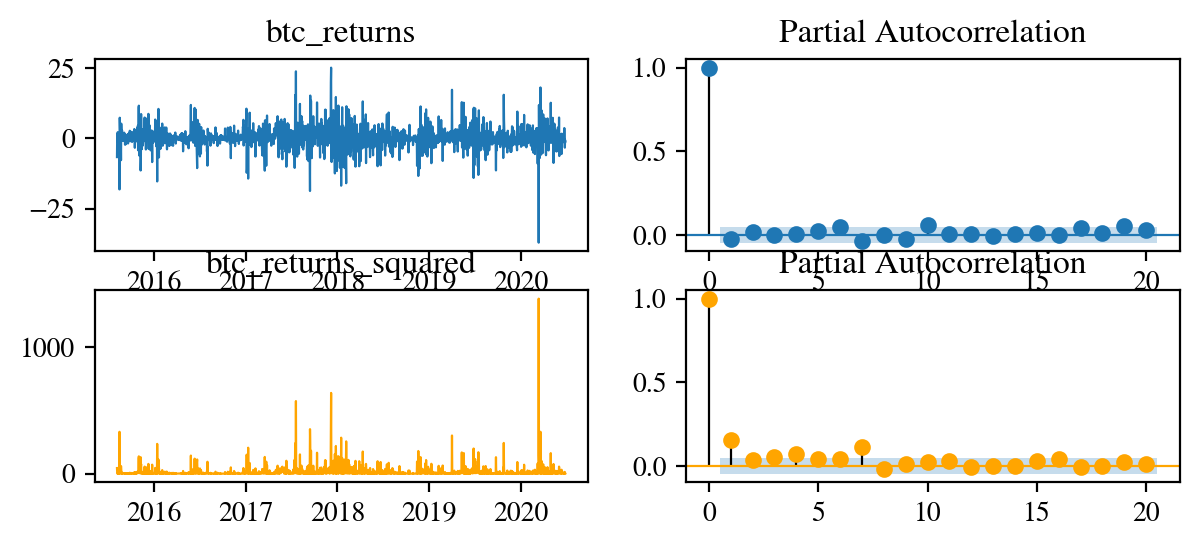

In [113]:
# plot pacf for returns and squared returns
from statsmodels.graphics.tsaplots import plot_pacf
fig_2, axs = plt.subplots(2,2)
axs[0][0].plot(btc_returns)
axs[0][0].set_title('btc_returns')
axs[1][0].plot(btc_returns_squared, color='orange')
axs[1][0].set_title('btc_returns_squared')
plot_pacf(btc_returns, ax= axs[0][1], lags=20)
plot_pacf(btc_returns_squared, ax= axs[1][1], lags=20, color='orange')

In [133]:
# Lagrange Multiplier Test

Date
2015-08-08   -6.645683
2015-08-09    1.563218
2015-08-10   -0.230119
2015-08-11    2.238439
2015-08-12   -1.483043
                ...   
2020-06-22    3.709197
2020-06-23   -0.197539
2020-06-24   -3.282047
2020-06-25   -0.523964
2020-06-26   -1.099753
Name: Close, Length: 1785, dtype: float64

In [142]:
# fit ARCH model to the returns
from arch import arch_model
model = arch_model(btc_returns, mean='constant', dist='t')
model_fitted = model.fit(last_obs= train.index[-1])
model_fitted.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 35465.57398817062
Iteration:      2,   Func. Count:     15,   Neg. LLF: 29302.684653303477
Iteration:      3,   Func. Count:     23,   Neg. LLF: 5323.340759371817
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4733.97371543129
Iteration:      5,   Func. Count:     37,   Neg. LLF: 4698.569631053519
Iteration:      6,   Func. Count:     44,   Neg. LLF: 4576.782837798135
Iteration:      7,   Func. Count:     51,   Neg. LLF: 3615.6901668639066
Iteration:      8,   Func. Count:     58,   Neg. LLF: 3595.5766931732087
Iteration:      9,   Func. Count:     64,   Neg. LLF: 3604.1207883232973
Iteration:     10,   Func. Count:     71,   Neg. LLF: 3905.0750991387054
Iteration:     11,   Func. Count:     80,   Neg. LLF: 3593.8966213791273
Iteration:     12,   Func. Count:     86,   Neg. LLF: 3593.8496834788402
Iteration:     13,   Func. Count:     92,   Neg. LLF: 3593.839574592188
Iteration:     14,   Func. Count:     98,   Neg. LLF: 3593

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                        Close   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:               -3593.84
Distribution:      Standardized Student's t   AIC:                           7197.68
Method:                  Maximum Likelihood   BIC:                           7223.99
                                              No. Observations:                 1426
Date:                      Sat, Aug 29 2020   Df Residuals:                     1421
Time:                              22:13:38   Df Model:                            5
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2288  4.573e-02      5.004  5.624e-07 [  0.139,  0.318]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1243  8.723e-02      1.425      0.154 [-4.664e-02,  0.295]
alpha[1]       0.1388  2.050e-02      6.771  1.281e-11  [9.862e-02,  0.179]
beta[1]        0.8612  2.854e-02     30.179 4.500e-200    [  0.805,  0.917]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.2669      0.179     18.245  2.249e-74 [  2.916,  3.618]
========================================================================

Covariance estimator: robust
"""

In [22]:
# save current model summary as LaTeX to .txt file
with open(save_plot_to+'ARCH_GARCH_logs_LaTeX.txt', 'a') as myfile:
    myfile.write(model_fitted.summary().as_latex()+'\n\n')

In [144]:
# obtain predicted volatility
model_pred = model_fitted.forecast(horizon= 1, align= 'target')
predicted_variance = model_pred.residual_variance[train.index[-1]:]

In [148]:
# plot predicted vs. actual variance
fig_3, ax = plt.subplots()
ax.plot(btc_returns.abs())
ax.plot(predicted_variance, color='red')
